In [1]:
import pandas as pd
import numpy as np
import os
import tqdm

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets import ImageFolder

from transformers import GPT2Tokenizer
from transformers import GPT2Config
from transformers import GPT2LMHeadModel
from transformers import AdamW

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


# Dataset visualization

We have two dataframes: reports and projections. Projections provide mapping between uid to image path and view of the scan (frontal or lateral). Reports provide mapping between uid and the findings.

For a given UID maximum projections are 5, and there are some UIDs for which findings are absent. We can probably fill those absent values from impression column, but for now since I am only building POC, I dropped such uids from the dataset.

I divided the UIDs into train and test set. I am assuming distinct UIDs belong to distinct patients, otherwise there might be data bleeding into test set.

In [5]:
img_base_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'

In [6]:
reports_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [7]:
projections_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [8]:
reports_df.shape, projections_df.shape

((3851, 8), (7466, 3))

In [9]:
projections_df.uid.value_counts().describe()

count    3851.000000
mean        1.938717
std         0.418264
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: count, dtype: float64

In [10]:
class ImageCaptionData:
    def __init__(self, reports_df, projections_df):
        self.reports_df = reports_df.set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = reports_df[reports_df.findings.notnull()].uid.unique()
        
    def get_sample(self):
        uid = np.random.choice(self.uids)
        images = list(self.projections_df.loc[[uid]]['filename'])
        projections = list(self.projections_df.loc[[uid]]['projection'])
        findings = self.reports_df.loc[uid]['findings']
        return uid, images, projections, findings

In [11]:
paired_dataset = ImageCaptionData(reports_df, projections_df)
uid, images, projections, findings = paired_dataset.get_sample()

In [12]:
def display_sample(uid, images, projections, findings):
    plt.figure(figsize=(10, 5))
    print("UID:", uid)
    for i, (img, proj) in enumerate(zip(images, projections)):
        plt.subplot(1, len(images), i+1)
        png_img = Image.open(os.path.join(img_base_dir, img))
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)

UID: 2796


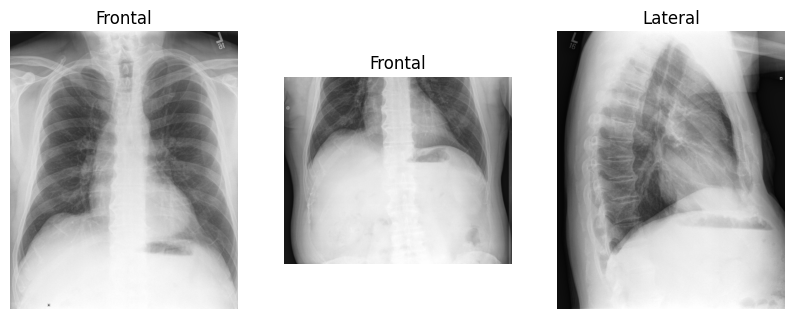

Findings: Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.


In [13]:
display_sample(uid, images, projections, findings)

In [14]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

# Setting up Language Model

With the resources available on Kaggle, I could only fit GPT-2 properly. For proof of concept we will just stick with GPT2 but Llama might be a better fit here due to its much superior performance. Several vision language models like Llava, MoonDream do infact use Llama model as the language model backbone. I believe finetuning one of those vision language models might have yielded better results, or perhaps directly using Llava-Med but for now I wanted to go with first principles so sticking to picking individual language and vision models.

I first fine-tuned gpt2 on the corpus of findings. This should improve GPT-2 alignment to medical report generation.

In [15]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [16]:
findings_corpus = [tokenizer.encode(line)  for line in reports_df[reports_df.uid.isin(train_uids)].findings.dropna()]

In [17]:
pd.Series([len(x) for x in findings_corpus]).describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95])

count    3003.000000
mean       51.048618
std        22.007258
min         8.000000
25%        37.000000
50%        48.000000
75%        61.000000
80%        67.000000
90%        80.000000
95%        92.000000
max       238.000000
dtype: float64

In [18]:
class GPT2Dataset(Dataset):
    def __init__(self, txt_list, max_length):
        self.input_ids = [torch.tensor(t[:max_length-1] + [tokenizer.eos_token_id]) for t in txt_list]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index]

def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
    return pad_sequence(batch, batch_first=True, padding_value=pad_id)

# Create dataset
dataset = GPT2Dataset(findings_corpus, max_length=128)  # Adjust max_length as needed
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)

In [19]:

model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [20]:
sample_reports = list(reports_df[reports_df.uid.isin(test_uids)].findings.dropna().sample(5))

In [21]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 The cardiac and mediastinal silhouettes are unremarkable. The lungs are well expanded and clear. There are no focal air space opacities. There is no pneumothorax or effusion. The bony structures of the thorax are intact with no evidence of acute osseous abnormality.
Generated report:
 The cardiac and mediastinal silhouettes of the two patients were compared. The mean age of each patient was 26.5 years (range, 18–28 years). The median age was 34.4 years.

RESULTS:
. In the first study, the mean cardiac volume was significantly higher in the patients with a history of heart failure (P = 0.01). In contrast, in this study the median cardiac volumes were significantly lower in patients who had a previous heart attack (p
------------
Sample report:
 The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute ab

In [22]:
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)

NUM_EPOCHS = 3 # Having larger number of epochs here was leading to complete overfitting on the report content
for epoch in range(NUM_EPOCHS):
    for batch in tqdm.auto.tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(batch.to(device), labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} completed')

  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 0 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 1 completed


  0%|          | 0/751 [00:00<?, ?it/s]

Epoch 2 completed


In [23]:
model.eval()
generated_texts = []
with torch.no_grad():
    for smp_report in sample_reports:
        prompt_text = " ".join(smp_report.split()[:5])
        encoded_input = tokenizer.encode(prompt_text, return_tensors='pt')
        encoded_input = encoded_input.to(device) 
        generated_sequences = model.generate(
            input_ids=encoded_input,
            max_length=100,  # Total length of output text (including the prompt)
            num_return_sequences=1,  # Number of sequences to generate
            temperature=0.7,  # Sampling temperature
            top_k=50,  # Top-k filtering
            top_p=0.95,  # Top-p (nucleus) filtering
            no_repeat_ngram_size=2,  # Prevent repetitions of n-grams
            pad_token_id=tokenizer.eos_token_id
        )
        generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
for smp, gen in zip(sample_reports, generated_texts):
    print("Sample report:\n", smp)
    print("Generated report:\n", gen)
    print("------------")

Sample report:
 The cardiac and mediastinal silhouettes are unremarkable. The lungs are well expanded and clear. There are no focal air space opacities. There is no pneumothorax or effusion. The bony structures of the thorax are intact with no evidence of acute osseous abnormality.
Generated report:
 The cardiac and mediastinal silhouettes are normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.
------------
Sample report:
 The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.
Generated report:
 The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.
-----

I did a qualitative evaluation of language model in report generation given first 5 words of the report. It does seem that fine tuning model, improved its ability to churn out more logical reports significantly.

In [24]:
model.save_pretrained('/kaggle/working/gpt-2-model')
tokenizer.save_pretrained('/kaggle/working/gpt-2-tokenizer')

('/kaggle/working/gpt-2-tokenizer/tokenizer_config.json',
 '/kaggle/working/gpt-2-tokenizer/special_tokens_map.json',
 '/kaggle/working/gpt-2-tokenizer/vocab.json',
 '/kaggle/working/gpt-2-tokenizer/merges.txt',
 '/kaggle/working/gpt-2-tokenizer/added_tokens.json')

# Setting up Joint Model

I will be using Swin Tranformer as vision encoder. If we remove classifcation head of Swin Transformer we are left with 768 dimensional encoding for our input. I will use a linear model to map this 768 dimensional image encoding to embedding space of language model. For our selected language model, embedding dim is also 768. Additionally I observed that individual embedding elements are mostly in the [-1, 1] range (with some outliers), so I applied a tanh nonlinearity on projection layer output to bring it in embedding space.

In [25]:
tokenizer = GPT2Tokenizer.from_pretrained('/kaggle/working/gpt-2-tokenizer')

vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()

In [26]:
MAX_SEQ_LENGTH  = 128
MAX_IMG_STACK = 5+1
BATCH_SIZE = 4

For preparing dataset, since the number of images for a UID can be variable we left pad images with zeros so that image component of data is stackable in a batch. Similarly we right pad text sequences to make them stackable. For images, since max number of projections was 5 we use 6 as MAX_IMAGE_STACK.

In [27]:
class ImageCaptionData(Dataset):
    def __init__(self, reports_df, projections_df, max_length=MAX_SEQ_LENGTH, max_img_stack=MAX_IMG_STACK):
        self.reports_df = reports_df.dropna(subset={'findings'}).set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = list(set(self.reports_df.index).intersection(self.projections_df.index))
        self.max_length = max_length
        self.max_img_stack = max_img_stack
        
    def __getitem__(self, index):
        uid = self.uids[index]
        image_paths = [os.path.join(img_base_dir, x) for x in list(self.projections_df.loc[[uid]]['filename'])]
        images = torch.stack([vision_preprocess(read_image(img ,ImageReadMode.RGB)) for img in image_paths])
        len_image_stack = len(image_paths)
        img_dim = images[0].shape
        images = torch.cat((torch.zeros((self.max_img_stack - len_image_stack, *img_dim)), images), dim=0)
        
        findings = tokenizer.encode(self.reports_df.loc[uid]['findings'])
        findings = torch.tensor(findings[:self.max_length-1]+ [tokenizer.eos_token_id])
        return len_image_stack, images, findings
    
    def __len__(self):
        return len(self.uids)
    
def collate_batch(batch):
    """
    Pad the batch to ensure all sequences have the same length.
    """
    len_images = torch.tensor([item[0] for item in batch])
    img_data = torch.stack([item[1] for item in batch])
    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        pad_id = tokenizer.eos_token_id
        
    tokens = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=pad_id)
    labels = pad_sequence([torch.cat((torch.tensor([-100]*MAX_IMG_STACK), item[2])) for item in batch], batch_first=True, padding_value=pad_id) 
    return [len_images, img_data, tokens, labels, pad_sequence([torch.ones(len(item[2])+MAX_IMG_STACK) for item in batch], batch_first=True, padding_value=0)]

In [28]:
train_dataset = ImageCaptionData(reports_df[reports_df.uid.isin(train_uids)], projections_df[projections_df.uid.isin(train_uids)])
test_dataset = ImageCaptionData(reports_df[~reports_df.uid.isin(train_uids)], projections_df[~projections_df.uid.isin(train_uids)])

In [29]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [30]:
x = next(iter(train_dataloader))
x[0].shape, x[1].shape, x[2].shape, x[3].shape, x[4].shape

(torch.Size([4]),
 torch.Size([4, 6, 3, 224, 224]),
 torch.Size([4, 98]),
 torch.Size([4, 104]),
 torch.Size([4, 104]))

In [31]:
lang_model = GPT2LMHeadModel.from_pretrained('/kaggle/working/gpt-2-model')

In [32]:
vision_model = models.swin_t(weights = models.swin_transformer.Swin_T_Weights.DEFAULT)
vision_model.head = nn.Identity() # strip off classification layer of swin transformer to get the image embedding

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 120MB/s]


In [33]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

In [34]:
class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [35]:
projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

I have frozen vision encoder, and will solely update params for language model and projection layer. Perhaps with some small lr everything can be jointly trained as well but I did not experiment much there.

In [38]:
# freeze vision model
vision_model.eval()
for param in vision_model.parameters():
    param.requires_grad = False

In [39]:
optimizer = torch.optim.Adam(
    [
        {"params": lang_model.parameters(), "lr": 2e-5},
        {"params": projection_model.parameters(), "lr": 5e-5}
    ]
)

In [40]:
NUM_EPOCHS = 5

In [41]:
MODEL_CHECKPOINTS_PATH = '/kaggle/working/checkpoints'
if not os.path.exists(MODEL_CHECKPOINTS_PATH):
    os.makedirs(MODEL_CHECKPOINTS_PATH)

In [42]:
import pdb

In [43]:
best_val_loss = np.inf

I left pad image encoder+projection output with bos_embedding so that image encoding. On some online forums I saw that this is somewhat incorrect for GPT, but since MedOmni mentions something similar I go ahead with it for now.

The image embeddings are then prepended to report embedding, and get fed into language model. Output labels are just the report prepended with empty tokens.

In [44]:
train_loss = []
for i in range(NUM_EPOCHS):
    train_batch_loss = []
    
    lang_model.train()
    projection_model.train()
    for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(train_dataloader):
        img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            # refetching bos_embedding to handle cases where bos_embedding might be trainable as well
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0,1))
        
        img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
        img_embed = bos_embedding*mask + (1-mask)*img_embed # replace images that are not present with bos embedding

        tok_embed = lang_model.get_input_embeddings()(tokens)
        input_embed = torch.cat((img_embed, tok_embed), dim=1)
        outputs = lang_model(
                inputs_embeds=input_embed,
                labels=labels,
                attention_mask=attn,
            )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item()/len(l_img))
        
    train_loss.append(train_batch_loss)
    
    lang_model.eval()
    projection_model.eval()
    aggregated_val_loss = []
    with torch.no_grad():
        for l_img, img, tokens, labels, attn in tqdm.auto.tqdm(test_dataloader):
            img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
            
            bos_embedding = lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*MAX_IMG_STACK).to(device))
            bos_embedding = torch.stack([bos_embedding]*len(l_img))
            mask = torch.stack([torch.cat([torch.ones(MAX_IMG_STACK-limg), torch.zeros(limg)]).repeat(LANG_MODEL_INPUT_DIM,1).T for limg in l_img]).to(device)
            img_embed = vision_model(img.flatten(0,1))
        
            img_embed = projection_model(img_embed).reshape(len(l_img), MAX_IMG_STACK, LANG_MODEL_INPUT_DIM)
            img_embed = bos_embedding*mask + (1-mask)*img_embed

            tok_embed = lang_model.get_input_embeddings()(tokens)
            input_embed = torch.cat((img_embed, tok_embed), dim=1)
            outputs = lang_model(
                    inputs_embeds=input_embed,
                    labels=labels,
                    attention_mask=attn,
                )

            loss = outputs.loss
            aggregated_val_loss.append(loss.item()/len(l_img))
    
    print("Epoch:", i, "Train Loss: {:.4f}".format(np.mean(train_batch_loss)), "Val Loss: {:.4f}".format(np.mean(aggregated_val_loss)))
    if (np.mean(aggregated_val_loss)<best_val_loss):
        best_val_loss = np.mean(aggregated_val_loss)
        epoch_checkpoint_path = os.path.join(MODEL_CHECKPOINTS_PATH, 'epoch_'+str(i))
        if not os.path.exists(epoch_checkpoint_path):
            os.makedirs(epoch_checkpoint_path)
        model.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-model'))
        tokenizer.save_pretrained(os.path.join(epoch_checkpoint_path, 'gpt-2-tokenizer'))
        torch.save(projection_model.state_dict(), os.path.join(epoch_checkpoint_path, 'projection_model.pth'))
        print("Saved checkpoint at "+ epoch_checkpoint_path)

  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 0.1683 Val Loss: 0.1651
Saved checkpoint at /kaggle/working/checkpoints/epoch_0


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.1533 Val Loss: 0.1636
Saved checkpoint at /kaggle/working/checkpoints/epoch_1


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.1457 Val Loss: 0.1621
Saved checkpoint at /kaggle/working/checkpoints/epoch_2


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.1387 Val Loss: 0.1624


  0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.1323 Val Loss: 0.1636


In [45]:
for param_group in optimizer.param_groups:
    param_group['lr'] = param_group['lr']*0.2

Unfortunately val loss starts increasing after first few epochs only. I had experimented a bit more with reduced learning rate but that did not help much. In interest of time, I simply pick the model from third epoch since that had best validation loss.

# Evaluation Mode

In [46]:
BEST_CHECKPOINT_PATH = "/kaggle/working/checkpoints/epoch_2/"
BEST_CHECKPOINT_PATH = epoch_checkpoint_path

In [47]:
VISION_MODEL_OUTPUT_DIM = 768
LANG_MODEL_INPUT_DIM = 768

class ProjectionModel(nn.Module):
    def __init__(self, vision_out_dim, lang_inp_dim):
        super(ProjectionModel, self).__init__()
        self.lin = nn.Linear(vision_out_dim, lang_inp_dim, bias=True)
    
    def forward(self, x):
        x = nn.functional.tanh(self.lin(x))
        return x

In [48]:
def load_best_checkpoint(checkpoint_path):
    vision_preprocess = models.swin_transformer.Swin_T_Weights.IMAGENET1K_V1.transforms()
    
    lang_model = GPT2LMHeadModel.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-model'))
    tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(checkpoint_path, 'gpt-2-tokenizer'))
    
    projection_model = ProjectionModel(VISION_MODEL_OUTPUT_DIM, LANG_MODEL_INPUT_DIM)
    projection_model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'projection_model.pth')))
    
    vision_model = models.swin_t(weights = models.swin_transformer.Swin_T_Weights.DEFAULT)
    vision_model.head = nn.Identity()
    
    vision_model.eval()
    projection_model.eval()
    lang_model.eval()
    return vision_model, projection_model, lang_model, tokenizer, vision_preprocess

In [49]:
vision_model, projection_model, lang_model, tokenizer, vision_preprocess = load_best_checkpoint(BEST_CHECKPOINT_PATH)

In [50]:
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
projection_model = projection_model.to(device)

In [51]:
def generate_report(image_paths):
    images = torch.stack([vision_preprocess(read_image(img,ImageReadMode.RGB)) for img in image_paths])
    len_image_stack = len(image_paths)

    with torch.no_grad():
        img_embed = vision_model(images.to(device))
        img_embed = projection_model(img_embed)

        # I found that padding here with bos token was actually causing issue with generation
        # probably because for gpt-2 bos_token=eos_token
        padded_img_embed = torch.cat([lang_model.get_input_embeddings()(torch.tensor([tokenizer.bos_token_id]*(MAX_IMG_STACK-len_image_stack)).to(device)), img_embed])

        generate_config = {
                    "eos_token_id": tokenizer.eos_token_id,
                    "bos_token_id": tokenizer.bos_token_id,
                    "pad_token_id": tokenizer.bos_token_id,
                    "max_new_tokens": 100,
                }

        output_ids = lang_model.generate(
            inputs_embeds=img_embed.unsqueeze(0), **generate_config
        )
    return tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

In [52]:
def compare_report(uid):
    print("Patient UID:", uid)
    
    uid_projection_df = projections_df[projections_df.uid==uid]
    image_paths = [os.path.join(img_base_dir, img_path) for img_path in uid_projection_df.filename]
    findings = reports_df[reports_df.uid==uid].findings.iloc[0]
    
    plt.figure(figsize=(10, 5))
    for i, (img, proj) in enumerate(zip(image_paths, list(uid_projection_df.projection))):
        if len(image_paths)>1:
            plt.subplot(1, len(image_paths), i+1)
        png_img = Image.open(img)
        png_img = png_img.convert('RGB')
        plt.title(proj)
        plt.imshow(png_img)
        plt.axis('off')
    plt.show()
    print("Findings:", findings)
    generated_report = generate_report(image_paths)
    print("Generated Report:", generated_report)

Following are some sample outputs from the vision-language model. I think the model mostly generates a normal report, even when there are some clinical abnormalities. I believe this might be due to skewed dataset in training. I would experiment some more with up weighing examples of clinical abnormalities. Using vision model that are better aligned for medical images, or more specifically Chest XRays.

There were some examples where an empty report got generated as well. I think a more heuristic based approach at generation step would help with that.

Patient UID: 3555


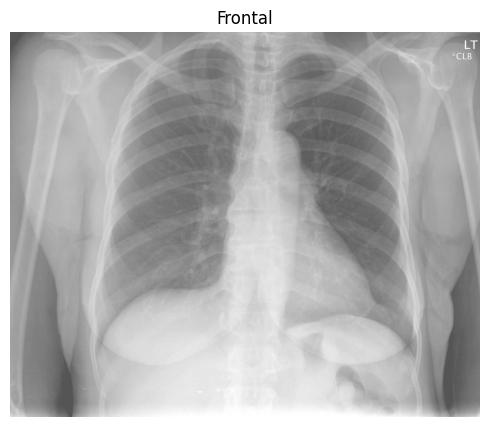

Findings: The heart and mediastinum are unremarkable. The lungs are clear without infiltrate. There is no effusion or pneumothorax. Degenerative disease of multiple midthoracic vertebral bodies.
Generated Report: iomegaly. The lungs are clear without focal consolidation, effusion, or pneumothorax. Normal heart size. Bony thorax and soft tissues grossly unremarkable


In [53]:
compare_report(np.random.choice(test_uids))

Patient UID: 3550


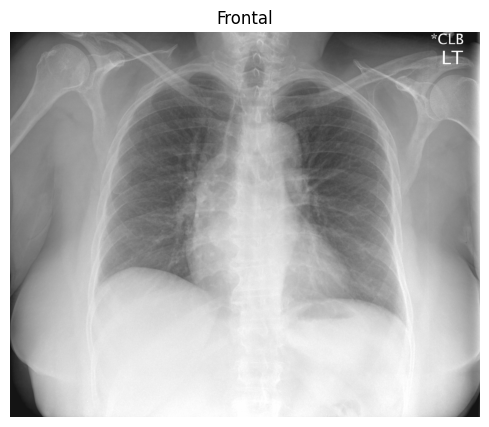

Findings: Normal heart size. Prominent contour of the ascending aorta, consistent with ectasia. Normal mediastinal contours. No focal airspace consolidation. No pleural effusion or pneumothorax. Minimal degenerative changes of the thoracic spine.
Generated Report:  XXXX and lateral views of the chest were obtained. The cardiomediastinal silhouette is normal in size and contour. The lungs are clear without focal consolidation, pneumothorax, or pleural effusion. There are no acute bony findings.


In [54]:
compare_report(np.random.choice(test_uids))

Patient UID: 267


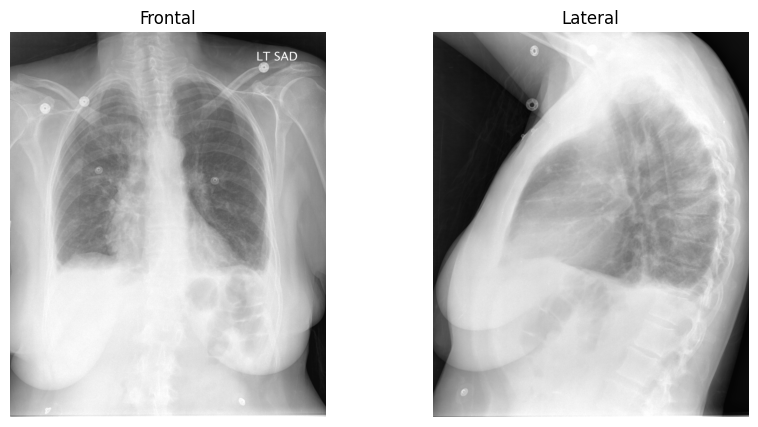

Findings: Endotracheal tube and NG tube have been removed. Mild patchy bilateral airspace disease. There are small bilateral pleural effusions. No pneumothorax. Heart and mediastinum are stable with normal size heart. Degenerative changes in the spine.
Generated Report:  XXXX. Normal heart size. No pneumothorax, pleural effusion, or focal airspace disease.


In [55]:
compare_report(np.random.choice(test_uids))

Patient UID: 3607


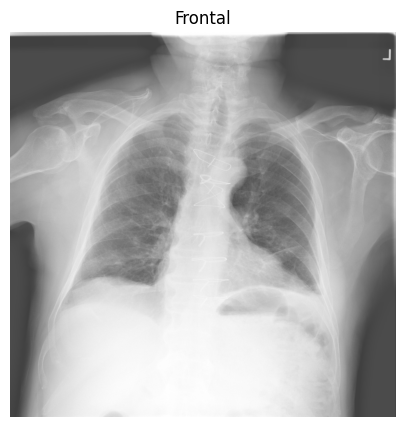

Findings: Heart size and pulmonary vascularity appear within normal limits. The patient is status post CABG. A few XXXX opacities are present in the left base, the appearance which XXXX scarring or atelectasis. No pneumothorax or pleural effusion is seen. Degenerative changes are present in the spine.
Generated Report: iomegaly. Lungs are clear without focal consolidation, effusion, or pneumothorax. Normal heart size. Bony thorax and soft tissues grossly unremarkable


In [56]:
compare_report(np.random.choice(test_uids))

Patient UID: 2830


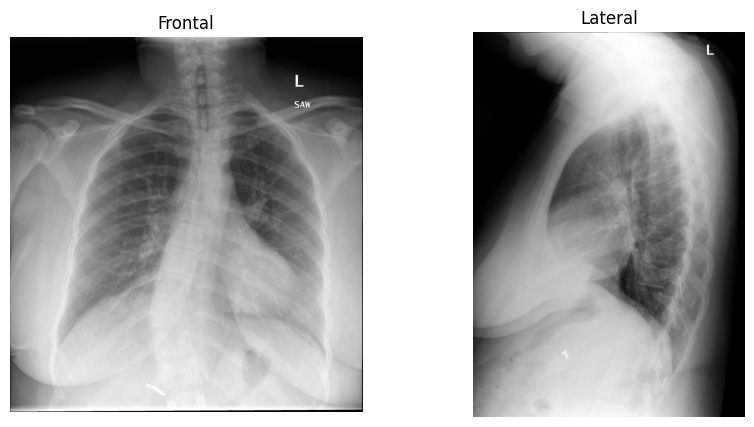

Findings: nan
Generated Report:  cardiomegaly. Normal heart size. No pneumothorax, pleural effusion, or focal airspace disease.
Patient UID: 2830


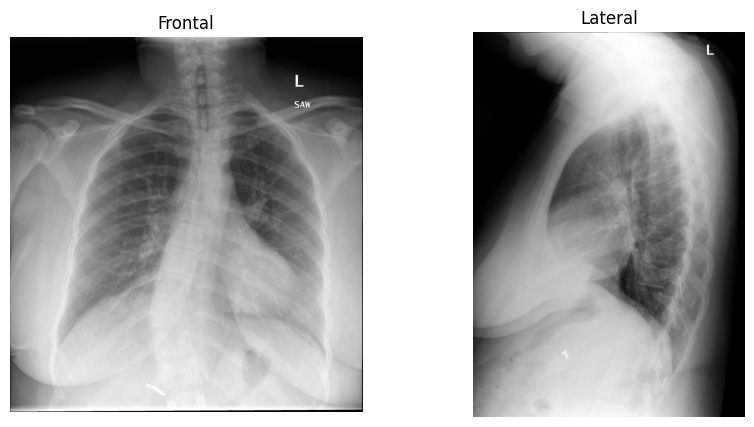

Findings: nan
Generated Report:  cardiomegaly. Normal heart size. No pneumothorax, pleural effusion, or focal airspace disease.
Patient UID: 2830


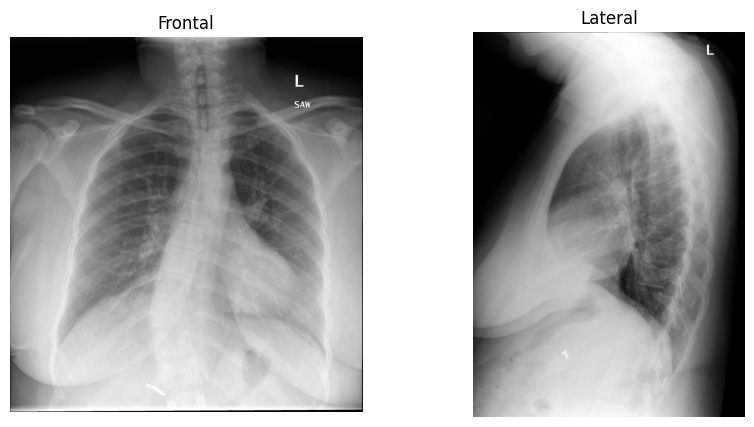

Findings: nan
Generated Report:  cardiomegaly. Normal heart size. No pneumothorax, pleural effusion, or focal airspace disease.


In [57]:
uid = np.random.choice(test_uids)
compare_report(uid)
compare_report(uid)
compare_report(uid)